# Lab 02 - Multi-Objective Optimization
## Tasks
- Plot travesal of scipy optimization on Rosenbrock function
- Conduct multi-objective optimization on AWA photoinjector example

# Set up environment

In [9]:
pip install git+https://github.com/uspas/2021_optimization_and_ml --quiet

Note: you may need to restart the kernel to use updated packages.


In [11]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

#import toy accelerator package
from uspas_ml.accelerator_toy_models import awa_model
import torch

#import pygmo
import pygmo as pg

In [25]:
# implementation of Rosenbrock function - see https://en.wikipedia.org/wiki/Test_functions_for_optimization
def rosen(x):
    '''
    x : input point shape (n,dim)
    dim : dimension of input space
    
    example usage
    rosen(np.random.rand(2,2), 2)    
    
    '''
    
    #do calculation
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)
    
#plot in 2D
def plot_rosen():
    n = 100
    x = np.linspace(-2,2,n)
    y = np.linspace(-1,3,n)
    xx = np.meshgrid(x,y)
    pts = np.vstack([ele.ravel() for ele in xx]).T
    
    f = []
    for pt in pts:
        f += [rosen(pt)]

    f = np.array(f)
    fig,ax = plt.subplots()
    c = ax.pcolor(*xx, f.reshape(n,n))
    fig.colorbar(c)
    
    return fig, ax

/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

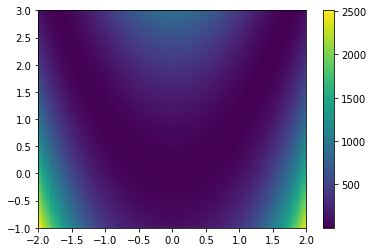

In [26]:
plot_rosen()

## Second order optimization methods of black box functions with restarts

<div class="alert alert-block alert-info">
    
**Task:**
Use `scipy.optimize.minimize()` implementation of the following methods (Nelder-Mead, L-BFGS-B, Powell) to optimize the 2D Rosenbrock function and plot the trajectory of each method through 2D space.

**Task:**
Write a second optimizer function that repeats L-BFGS-B optimization of a 10D Rosenbrock function starting with 10 different random initial points and return the best results. 
    
</div>

In [29]:
#your code here

      fun: 3.7461927208730536e-11
 hess_inv: array([[0.48965874, 0.97921278],
       [0.97921278, 1.96321588]])
      jac: array([-5.71761226e-07, -1.35533544e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 17
     njev: 24
   status: 0
  success: True
        x: array([0.99999388, 0.99998775])


## Multi-objective optimization
Here we will find the pareto front of the AWA photoinjector problem (see below). Input variables are shown in red and output variables are shown in blue. Both the inputs and outputs are normalized to [-1,1]. Our goal is to minimize all of the output beam parameters.

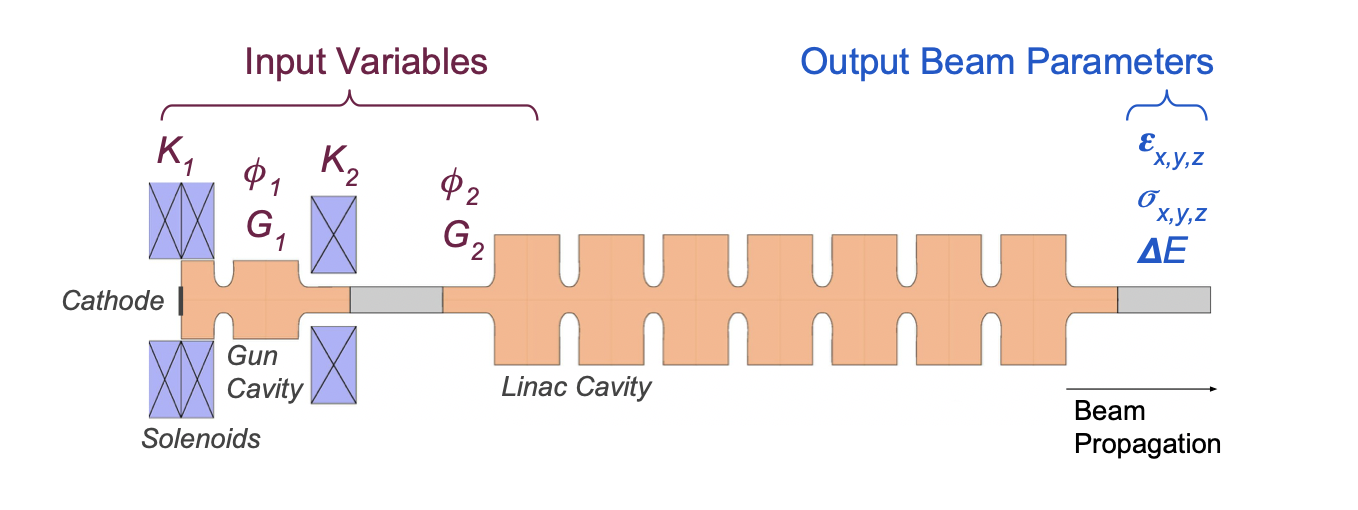

In [14]:
# get AWA model
model = awa_model.AWAModel()
print(model.features)
print(model.targets)

x = torch.rand(5,6)
model.predict(x)

['P0', 'P1', 'G0', 'G1', 'K1', 'K2']
['rms_x', 'rms_y', 'rms_s', 'emit_x', 'emit_y', 'emit_s', 'dE']


tensor([[-0.5145, -0.5116, -0.8261, -0.6635, -0.6768, -0.8569, -0.2172],
        [-0.7520, -0.7311, -0.6441, -0.7269, -0.7270, -0.7522,  0.0895],
        [-0.6095, -0.6040, -0.7576, -0.6769, -0.6897, -0.8209, -0.1281],
        [-0.7361, -0.7254, -0.6252, -0.6710, -0.6778, -0.7701, -0.0713],
        [-0.5227, -0.5203, -0.7467, -0.6593, -0.6739, -0.8285, -0.1959]],
       grad_fn=<TanhBackward>)

## First try multi-objective optimization on a test problem
To start with we try a test problem - see description here https://datacrayon.com/posts/search-and-optimisation/practical-evolutionary-algorithms/synthetic-objective-functions-and-zdt1/ and here (page 488) https://ro.ecu.edu.au/cgi/viewcontent.cgi?article=3021&context=ecuworks

In [18]:
zdt = pg.problem(pg.zdt())

In [16]:
#do example NSGA-II optimization

# create population
pop = pg.population(zdt, size=20)
# select algorithm
algo = pg.algorithm(pg.nsga2(gen=1))
algo.set_verbosity(100)
print(algo)
# run optimization
pop = algo.evolve(pop)
# extract results
fits, vectors = pop.get_f(), pop.get_x()

Algorithm name: NSGA-II: [stochastic]
	C++ class name: pagmo::nsga2

	Thread safety: basic

Extra info:
	Generations: 1
	Crossover probability: 0.95
	Distribution index for crossover: 10
	Mutation probability: 0.01
	Distribution index for mutation: 50
	Seed: 2750693800
	Verbosity: 100


<div class="alert alert-block alert-info">
    
**Task:**
Plot the Pareto front and calculate the front hypervolume with the reference point (11,11). See https://esa.github.io/pygmo2/tutorials/moo.html and https://esa.github.io/pygmo2/tutorials/tutorials.html#hypervolumes for utilities.
    
</div>

In [17]:
#define problem class for pygmo
class AWAProblem:
    def __init__(self):
        self.model = awa_model.AWAModel()
    
    def get_nobj(self):
        return 7

    def fitness(self, x):
        x = torch.tensor(x).reshape(1,-1).float()
        return self.model.predict(x).detach().numpy().flatten().astype(np.float)
    
    def get_bounds(self):
        return ([-1]*6,[1]*6)

<div class="alert alert-block alert-info">
    
**Task:**
Use the above code to find the 7D pareto front of the AWA multi-objective problem. Plot the front projected onto the bunch length vs. horizontal emittance subspace.
    
</div>